In [1]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

In [2]:
api_key = #API key goes here

In [3]:
channel_ids = ['UC2UXDak6o7rBm23k3Vv5dww',
               # more channels here
              ]

In [4]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [5]:
def get_channel_stats(youtube, channel_ids):
    
    """
    Get channel stats
    
    Params:
    ------
    youtube: build object of Youtube API
    channel_ids: list of channel IDs
    
    Returns:
    ------
    dataframe with all channel stats for each channel ID
    
    """
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return(pd.DataFrame(all_data))

def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids
    
    
def get_video_details(youtube, video_ids):

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)

In [6]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [7]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Tina Huang,363000,14051769,104,UU2UXDak6o7rBm23k3Vv5dww


In [8]:
playlist_id = "UU2UXDak6o7rBm23k3Vv5dww"

In [9]:
# Get video IDs
video_ids = get_video_ids(youtube, playlist_id)

In [10]:
#count of Tina Huang videos
len(video_ids)

104

In [11]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,A3x0gYW42Ts,Tina Huang,In Defense of Hustle Culture,Head to http://brilliant.org/TinaHuang/ to get...,None,2022-07-10T15:00:06Z,35019,1925,None,256,PT19M40S,hd,false
1,egBzpILuNhA,Tina Huang,Why the best students are NOT the most successful,Start building your ideal daily routine! The f...,None,2022-06-27T15:00:26Z,62669,3672,None,339,PT16M34S,hd,false
2,SQNzij5m_Yg,Tina Huang,How to Make a Self Study Plan (that you don't ...,✉️ NEWSLETTER: https://tinahuang.substack.com/...,None,2022-06-19T16:30:03Z,42140,2593,None,194,PT20M,hd,false
3,8tpha6FIa_k,Tina Huang,I left Meta...and I'm lowkey freaking out 🥲,I refilmed this video 3 times and then sat on ...,None,2022-06-09T14:45:00Z,205694,11549,None,795,PT11M25S,hd,false
4,UvqN3bAv0pM,Tina Huang,Why you keep quitting online courses (and then...,Head to http://brilliant.org/TinaHuang/ to get...,None,2022-06-02T16:49:09Z,219731,9020,None,721,PT14M2S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,mueI-I7Suxw,Tina Huang,"3rd Year Statistics, Data Science, Computer S...",You should watch this video if you are applyin...,"[data science resume, software engineering res...",2020-08-08T12:08:36Z,5823,175,None,24,PT14M36S,hd,false
100,-zQ-Pf491bQ,Tina Huang,How I Became a Data Scientist | Computer Scien...,This is part 2 of my internship and job search...,"[upenn, mcit, data science, software engineeri...",2020-08-02T21:44:56Z,13593,403,None,41,PT7M52S,hd,false
101,Rx1i1J4m4MQ,Tina Huang,How I got Software Engineering and Data Scienc...,I got Amazon and Goldman Sachs internships for...,"[computer science, mcit, upenn, university of ...",2020-07-28T16:48:31Z,25971,875,None,65,PT9M48S,hd,false
102,JUkSeqe1eYQ,Tina Huang,How to choose between software engineering and...,Software Engineering vs Data Science? Last yea...,"[data science, software engineering, data scie...",2020-07-22T06:00:57Z,308992,14335,None,606,PT7M56S,hd,false


In [12]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [13]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [14]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [15]:
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [16]:
# convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [17]:
video_df[['durationSecs', 'duration']] 

,durationSecs,duration
0,1180.0,PT19M40S
1,994.0,PT16M34S
2,1200.0,PT20M
3,685.0,PT11M25S
4,842.0,PT14M2S
...,...,...
99,876.0,PT14M36S
100,472.0,PT7M52S
101,588.0,PT9M48S
102,476.0,PT7M56S


In [18]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [19]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount
0,A3x0gYW42Ts,Tina Huang,In Defense of Hustle Culture,Head to http://brilliant.org/TinaHuang/ to get...,None,2022-07-10 15:00:06+00:00,35019.0,1925.0,NaN,256.0,PT19M40S,hd,false,Sunday,1180.0,0
1,egBzpILuNhA,Tina Huang,Why the best students are NOT the most successful,Start building your ideal daily routine! The f...,None,2022-06-27 15:00:26+00:00,62669.0,3672.0,NaN,339.0,PT16M34S,hd,false,Monday,994.0,0
2,SQNzij5m_Yg,Tina Huang,How to Make a Self Study Plan (that you don't ...,✉️ NEWSLETTER: https://tinahuang.substack.com/...,None,2022-06-19 16:30:03+00:00,42140.0,2593.0,NaN,194.0,PT20M,hd,false,Sunday,1200.0,0
3,8tpha6FIa_k,Tina Huang,I left Meta...and I'm lowkey freaking out 🥲,I refilmed this video 3 times and then sat on ...,None,2022-06-09 14:45:00+00:00,205694.0,11549.0,NaN,795.0,PT11M25S,hd,false,Thursday,685.0,0
4,UvqN3bAv0pM,Tina Huang,Why you keep quitting online courses (and then...,Head to http://brilliant.org/TinaHuang/ to get...,None,2022-06-02 16:49:09+00:00,219731.0,9020.0,NaN,721.0,PT14M2S,hd,false,Thursday,842.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,mueI-I7Suxw,Tina Huang,"3rd Year Statistics, Data Science, Computer S...",You should watch this video if you are applyin...,"[data science resume, software engineering res...",2020-08-08 12:08:36+00:00,5823.0,175.0,NaN,24.0,PT14M36S,hd,false,Saturday,876.0,24
100,-zQ-Pf491bQ,Tina Huang,How I Became a Data Scientist | Computer Scien...,This is part 2 of my internship and job search...,"[upenn, mcit, data science, software engineeri...",2020-08-02 21:44:56+00:00,13593.0,403.0,NaN,41.0,PT7M52S,hd,false,Sunday,472.0,15
101,Rx1i1J4m4MQ,Tina Huang,How I got Software Engineering and Data Scienc...,I got Amazon and Goldman Sachs internships for...,"[computer science, mcit, upenn, university of ...",2020-07-28 16:48:31+00:00,25971.0,875.0,NaN,65.0,PT9M48S,hd,false,Tuesday,588.0,11
102,JUkSeqe1eYQ,Tina Huang,How to choose between software engineering and...,Software Engineering vs Data Science? Last yea...,"[data science, software engineering, data scie...",2020-07-22 06:00:57+00:00,308992.0,14335.0,NaN,606.0,PT7M56S,hd,false,Wednesday,476.0,16


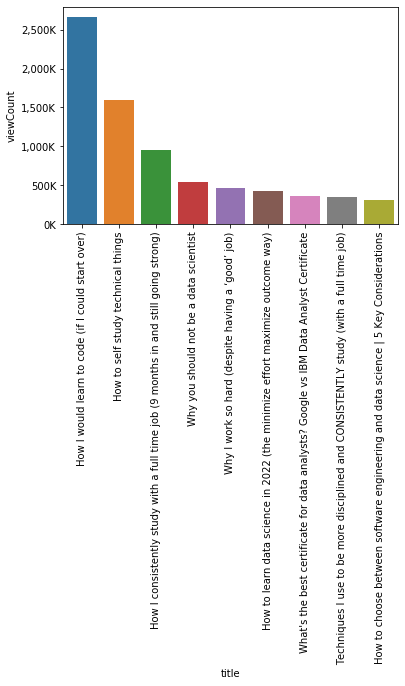

In [20]:
#Tinas top 10 most popular video, 1 is over 2.5 million views
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

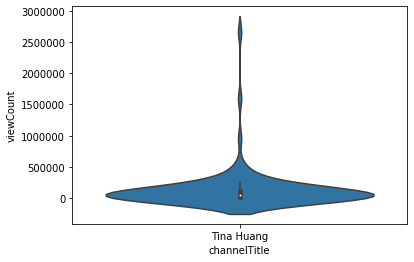

In [22]:
#distribution of video views
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])

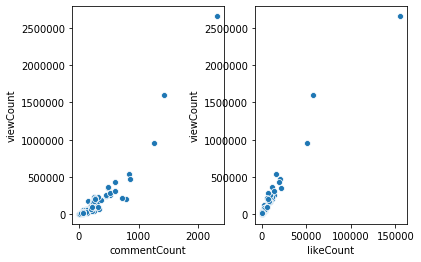

In [23]:
#comment and like count
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

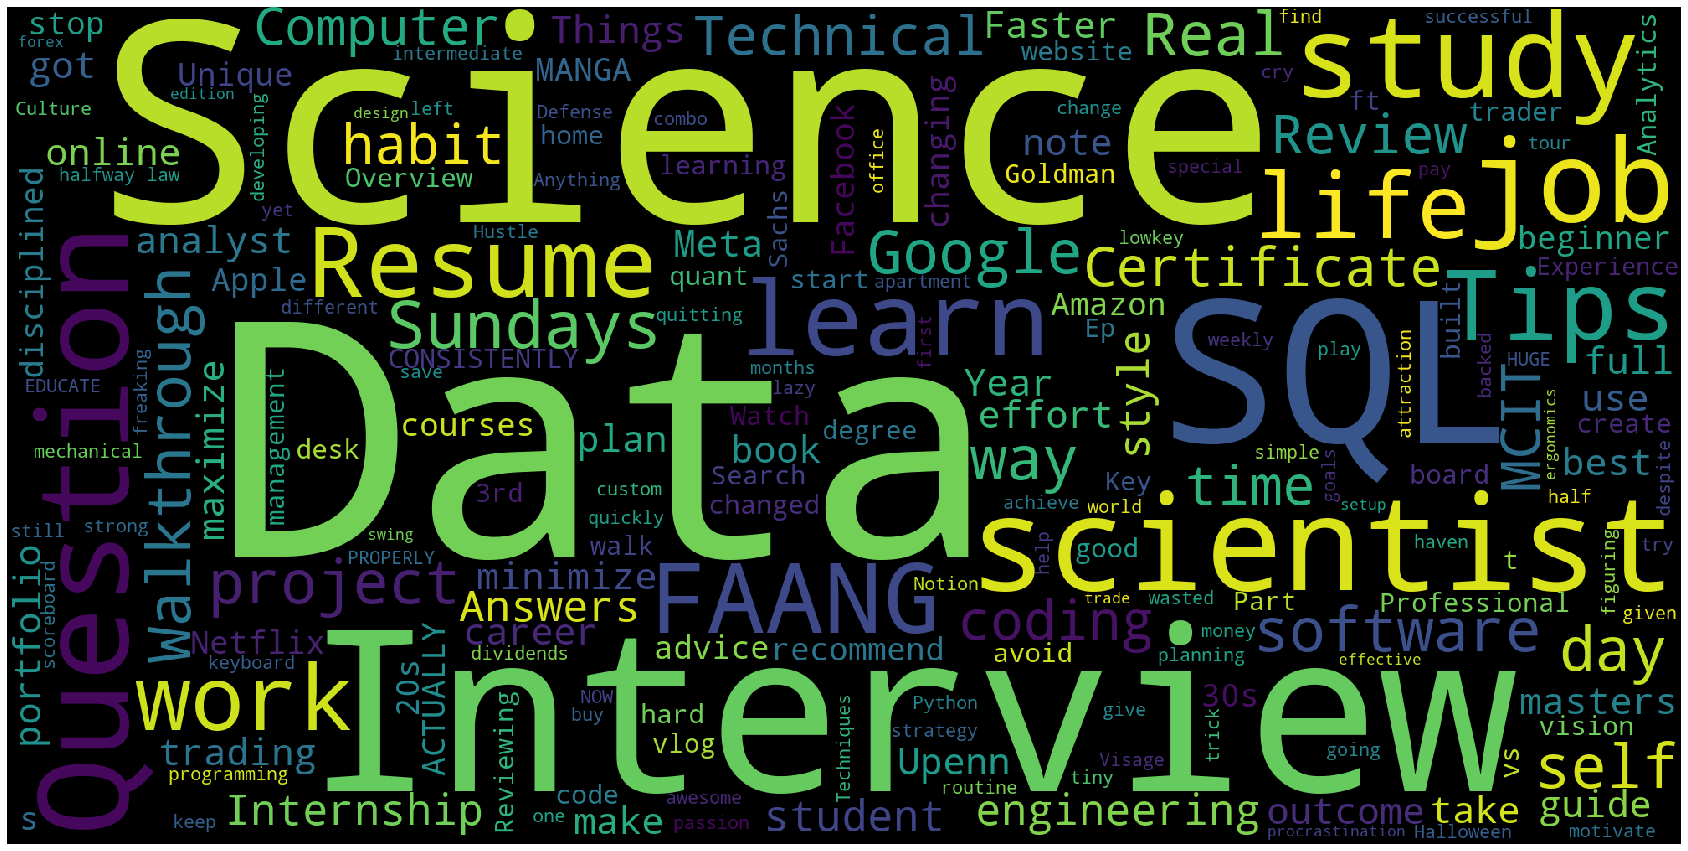

In [27]:
#word cloud, most popular words used in title
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

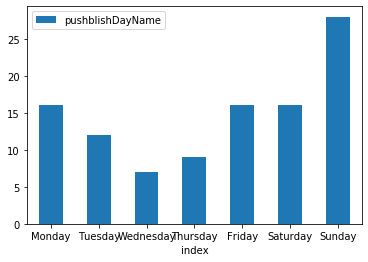

In [28]:
#which days she uploads the most
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)